# Vet a Known Exoplanet
This notebook pulls the parameters and light curve of a known exoplanet, WASP-18 b. It then runs three vetters on on that TCE and light curve.

In [3]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.model import create_box_model_for_tce
from exovetter.tce import Tce
from exovetter import vetters as vet

In [4]:
%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
header={}

## Create a TCE using exo.MAST requests.

In [5]:
planet_name = "WASP-18 b"

url = planeturl + "/identifiers/"
myparams = {"name":planet_name}
r = requests.get(url = url, params = myparams, headers = header)
planet_names = r.json()
ticid = planet_names['tessID']
tceid = planet_names['tessTCE']

In [6]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()
nexsci_prop = planet_prop[1]  #Second one returned

Catalog 2: nexsci


In [7]:
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Get a lightkurve for this object

In [8]:
lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
lc = lcf.SAP_FLUX.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

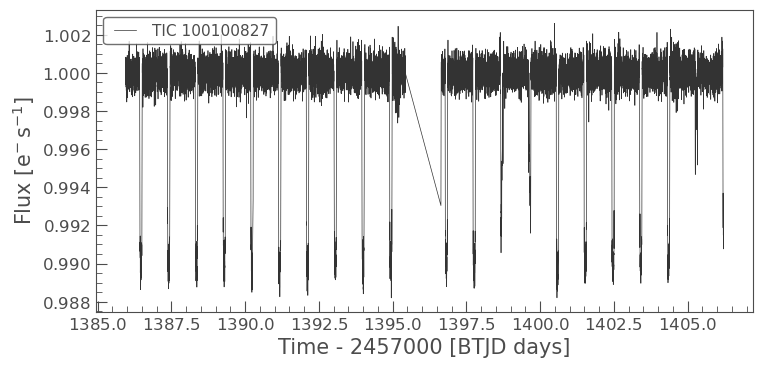

In [9]:
flat.plot()

In [10]:
lpp = vet.Lpp(lc_name="flux")
_ = lpp.run(tce,flat)

/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/lpp.py:380: UserWarning: LPP requires a MES or SNR value stored as snr in the tce. Using a value of 10.0.
  warnings.warn('LPP requires a MES or SNR value stored as snr '
/Users/smullally/Python_Code/exovetter-repos/official/exovetter/exovetter/lpp.py:369: UserWarning: Removing median. The supplied light curve isnot normalized to zero.
  warnings.warn("Removing median. The supplied light curve is" \


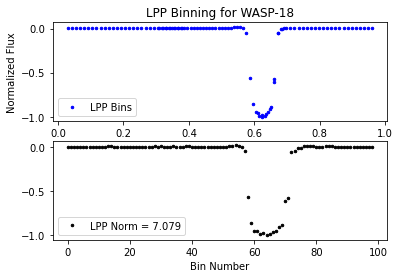

In [11]:
lpp.plot()

/Users/smullally/anaconda/envs/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/smullally/anaconda/envs/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


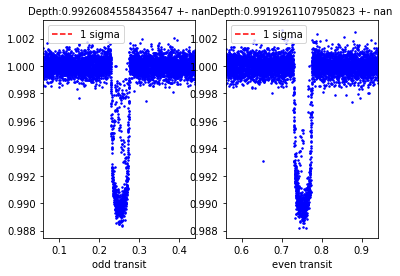

In [12]:
oe = vet.OddEven()
_ = oe.run(tce,flat)
oe.plot()

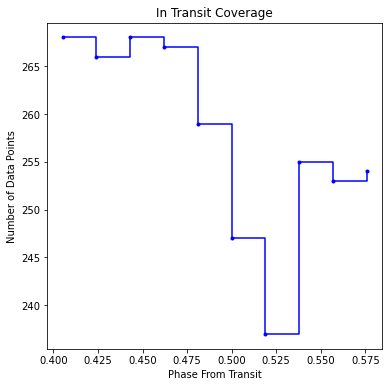

In [13]:
tcover = vet.TransitPhaseCoverage()
_ = tcover.run(tce,flat)
tcover.plot()

In [15]:
tcover.lc_name

'flux'

In [16]:
tcover.__dict__

{'lc_name': 'flux',
 'time': array([1385.95220258, 1385.95359146, 1385.95498034, ..., 1406.21438965,
        1406.2157785 , 1406.21716735]),
 'flux': array([1.00080132, 0.99940657, 1.00069271, ..., 0.99180555, 0.99076658,
        0.99198054]),
 'tp_cover': 1.0,
 'hist': array([268, 266, 268, 267, 259, 247, 237, 255, 253, 254]),
 'bins': array([0.40510391, 0.42408312, 0.44306234, 0.46204156, 0.48102078,
        0.5       , 0.51897922, 0.53795844, 0.55693766, 0.57591688,
        0.59489609])}

In [18]:
flat.to_csv('/Users/smullally/Python_Code/exovetter-repos/official/exovetter/tests/wasp18b_flat_lightcurve.csv')

In [19]:
wasp18 = lc.csv

Signature: lc.from_timeseries(ts)
Docstring:
Creates a new `LightCurve` from an AstroPy
`~astropy.timeseries.TimeSeries` object.

Parameters
----------
ts : `~astropy.timeseries.TimeSeries`
    The AstroPy TimeSeries object.  The object must contain columns
    named 'time', 'flux', and 'flux_err'.
File:      ~/anaconda/envs/python37/lib/python3.7/site-packages/lightkurve/lightcurve.py
Type:      function


In [ ]:
wasp18 = lc.from_timeseries

In [21]:
import pandas as p
data = p.read_csv('/Users/smullally/Python_Code/exovetter-repos/official/exovetter/tests/wasp18b_flat_lightcurve.csv')

In [24]:
wasp18 = lk.LightCurve(time=data['time'], flux = data['flux'])

<AxesSubplot:xlabel='Time', ylabel='Flux'>

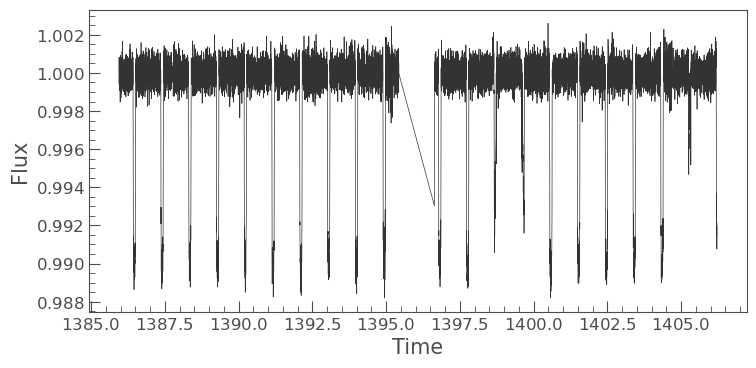

In [25]:
wasp18.plot()

In [26]:
tce.__dict__

{}

In [27]:
tce

{'period': <Quantity 0.94124 d>,
 'epoch': <Quantity 58374.669883 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.00990112>,
 'duration': <Quantity 0.08932 d>,
 'event_name': 'WASP-18 b',
 'target_name': 'WASP-18'}

In [34]:
from astropy.io import ascii

w = ascii.read('/Users/smullally/Python_Code/exovetter-repos/official/exovetter/tests/wasp18b_flat_lightcurve.csv', data_start=1)

In [35]:
w

col1,col2,col3,col4
int64,float64,float64,float64
0,1385.9522025788885,1.000801322708839,0.0005353269908588478
1,1385.953591461384,0.9994065714409809,0.0005349626756345742
2,1385.954980343879,1.0006927083353505,0.00053526818502222
3,1385.9563692263732,1.0008286534411353,0.0005353168295899013
4,1385.9577581088686,0.9997915941745023,0.0005351319742807559
5,1385.959146991364,1.0000743929239353,0.0005351355691123532
6,1385.960535873859,1.0004386846059148,0.000535205176882188
7,1385.961924756587,0.9993898784957184,0.0005350902329530936
8,1385.9633136390817,0.9999839282821227,0.0005350977999758051


In [31]:
w['time']

KeyError: 'time'